Plan

1. Preprocess data

2. Find variables with high correlation with tip amount variable

3. Use a RandomForestRegressor + RandomizedSearchCV to build a prediction model

4. Find feature importance of variables after model is finished training

5. Summarize results

# Data preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root = './drive/MyDrive/Colab Notebooks/ADA-1005-Project'

In [21]:
import pandas as pd
import numpy as np

# concatenate all files into single dataframe
# alldata = (pd.read_parquet(f"cleaned_data/1.parquet")).head(1500000)
alldata = pd.DataFrame()
frames = []
for i in range(1, 13):
  data = pd.read_parquet(f"{root}/{i}.parquet").head(1500000)
  frames.append(data)
alldata = pd.concat(frames)

In [22]:
# turn date-time into numerical values
alldata['tpep_pickup_datetime'] = pd.to_datetime(alldata['tpep_pickup_datetime']).astype('int64') // 10e5
alldata['tpep_dropoff_datetime'] = pd.to_datetime(alldata['tpep_dropoff_datetime']).astype('int64') // 10e5

# turn 'N' and 'Y' into 0 and 1
alldata["store_and_fwd_flag"] = alldata["store_and_fwd_flag"].map(lambda x: 0 if x == "N" else 1)

try: # If there is an "Airport fee column"
    # fillNA with zeroes
    alldata["airport_fee"] = alldata["airport_fee"].fillna(0.00)
    alldata["Airport_fee"] = alldata["Airport_fee"].fillna(0.00)
    alldata["airport_fee"] = np.maximum(alldata['airport_fee'], alldata['Airport_fee'])

    # drop unwanted columns
    alldata = alldata.drop(columns=["Airport_fee", "total_amount", 'yyyy-mm'])
except:
    alldata["airport_fee"] = alldata["airport_fee"].fillna(0.00)
    alldata = alldata.drop(columns=["total_amount", 'yyyy-mm'])

# change the negative values to positive
alldata = alldata.abs()

# one-hot encode nominal categories
alldata = pd.get_dummies(alldata, columns=['VendorID', 'RatecodeID', 'payment_type'], prefix_sep='_', dtype=int)

# drop the values with negative tip_amount/fare_amount
alldata = alldata[(alldata['fare_amount'] >= 0) & (alldata['tip_amount'] >= 0)]

# change all to floats
alldata = alldata.astype({col: float for col in alldata.select_dtypes(include='int').columns})

# drop some redundant columns
alldata = alldata.drop(columns=['improvement_surcharge', 'payment_type_5', 'store_and_fwd_flag'])

# print(alldata.columns)
# print(alldata.dtypes)
alldata.head()
# sorted_stuff = alldata.sort_values(by='total_amount')

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,...,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,payment_type_1,payment_type_2,payment_type_3,payment_type_4
0,1.672533e+09,1.672534e+09,1.0,0.97,161.0,141.0,9.3,1.00,0.5,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.672535e+09,1.672535e+09,1.0,1.10,43.0,237.0,7.9,1.00,0.5,4.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.672533e+09,1.672533e+09,1.0,2.51,48.0,238.0,14.9,1.00,0.5,15.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.672531e+09,1.672532e+09,0.0,1.90,138.0,7.0,12.1,7.25,0.5,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.672532e+09,1.672532e+09,1.0,1.43,107.0,79.0,11.4,1.00,0.5,3.28,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Variable Correlations

In [23]:
!pip install seaborn

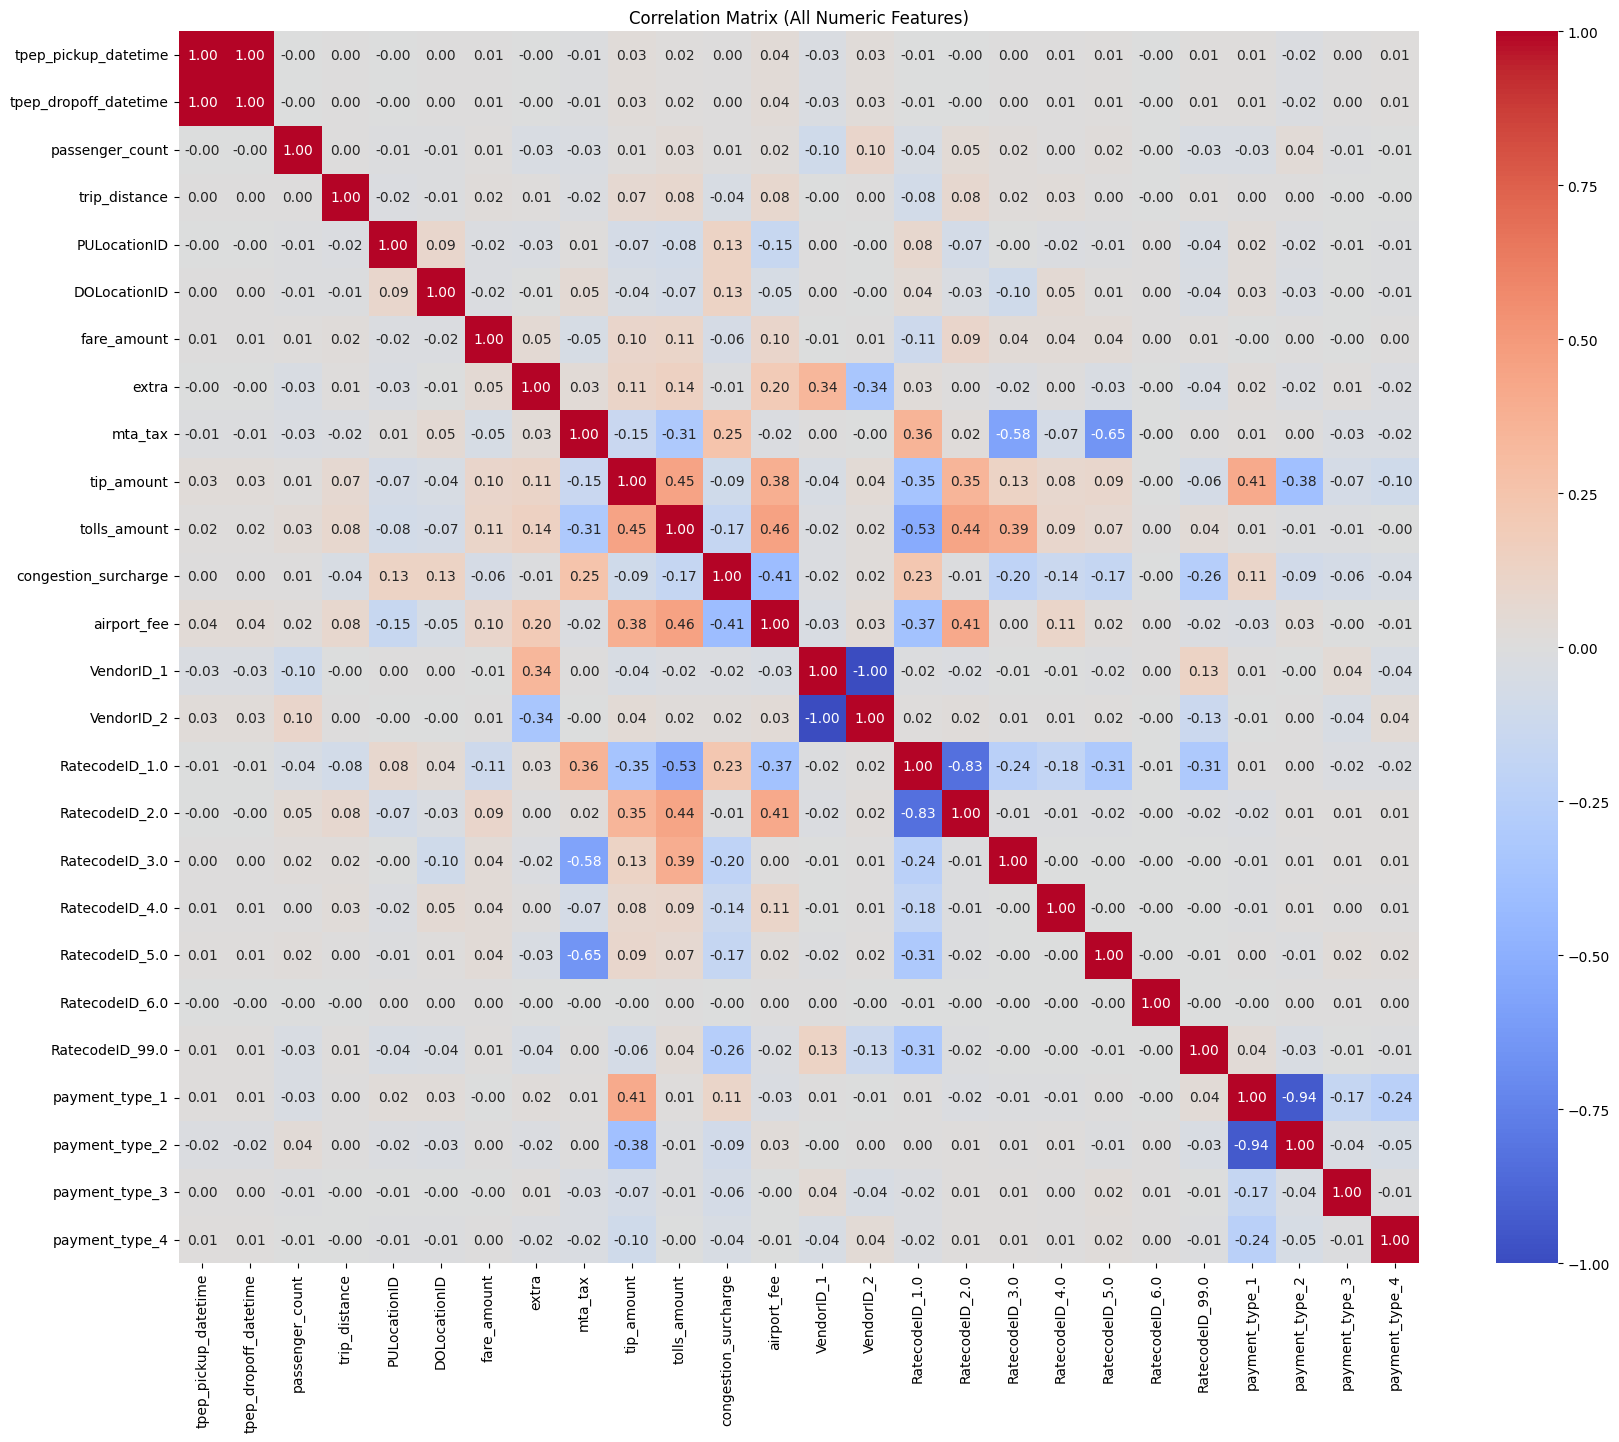

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select all numeric columns (both float and integer types)
numericals = alldata.select_dtypes(include=['number'])

# Calculate the full correlation matrix for all numeric columns
corr_matrix = numericals.corr()

# Plot heatmap for the full 2D correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix (All Numeric Features)')
plt.show()

# Build a Random Forest model

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
from sklearn.decomposition import PCA

# Load data and split into features and target
X = alldata.drop("tip_amount", axis=1)
y = alldata["tip_amount"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Reduce dimensionality to using PCA
pca = PCA(n_components=10, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Reduce the number of data entries by randomly selecting a smaller subset
subset_size = int(0.05 * len(X_train))
subset_idx = np.random.choice(X_train_pca.shape[0], subset_size, replace=False)
X_subset = X_train_pca[subset_idx]
y_subset = y_train.iloc[subset_idx]

print("Initital:")
print(X.shape)
print(y.shape)

print("Reduced")
print(X_subset.shape)
print(y_subset.shape)

Initital:
(18000000, 25)
(18000000,)
Reduced
(720000, 10)
(720000,)


In [29]:
# Initialize the Random Forest Regressor
forest = RandomForestRegressor(random_state=0, max_features=9, n_jobs=8)

# Define hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 250),
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': randint(2, 7),
    'min_samples_leaf': randint(1, 5)
}

# param_dist = {
#     'n_estimators': [188],
#     'max_depth': [20],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
# }


# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_dist,
    n_iter=3,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=0,
    n_jobs=-1
)

# Train the model on the PCA-transformed data
random_search.fit(X_subset, y_subset)
print(f'Best Parameters: {random_search.best_params_}')

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 188}


In [30]:
# Embed the reduced data back (approximation)
X_train_reconstructed = pca.inverse_transform(X_train_pca)
X_test_reconstructed = pca.inverse_transform(X_test_pca)

print("Reconstructed")
print(X_train_reconstructed.shape)
print(X_test_reconstructed.shape)

Reconstructed
(14400000, 25)
(3600000, 25)


In [34]:
# Optional: Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {mse}')

# Use the Best Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_subset)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_subset, y_pred))
print(f'RMSE: {rmse:.2f}')

Test MSE: 6.137054364289078
RMSE: 1.62


Extract the important features

In [35]:
# Get feature importances for the PCA components
pca_importances = best_model.feature_importances_  # Shape:

# Map importances back to original features using PCA loadings (components_)
original_feature_importances = np.dot(pca_importances, pca.components_)  # Shape:

In [36]:
# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': original_feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

                  Feature  Importance
6             fare_amount    0.426967
10   congestion_surcharge    0.203958
3           trip_distance    0.076855
7                   extra    0.056028
0    tpep_pickup_datetime    0.050553
4            PULocationID    0.045553
9            tolls_amount    0.042120
2         passenger_count    0.034632
21         payment_type_1    0.033617
5            DOLocationID    0.031794
14         RatecodeID_1.0    0.010929
12             VendorID_1    0.002981
8                 mta_tax    0.002646
15         RatecodeID_2.0    0.001920
19         RatecodeID_6.0   -0.000002
16         RatecodeID_3.0   -0.001557
17         RatecodeID_4.0   -0.001899
23         payment_type_3   -0.001913
24         payment_type_4   -0.002084
13             VendorID_2   -0.002981
18         RatecodeID_5.0   -0.003660
20        RatecodeID_99.0   -0.005732
1   tpep_dropoff_datetime   -0.011131
22         payment_type_2   -0.029620
11            airport_fee   -0.058642


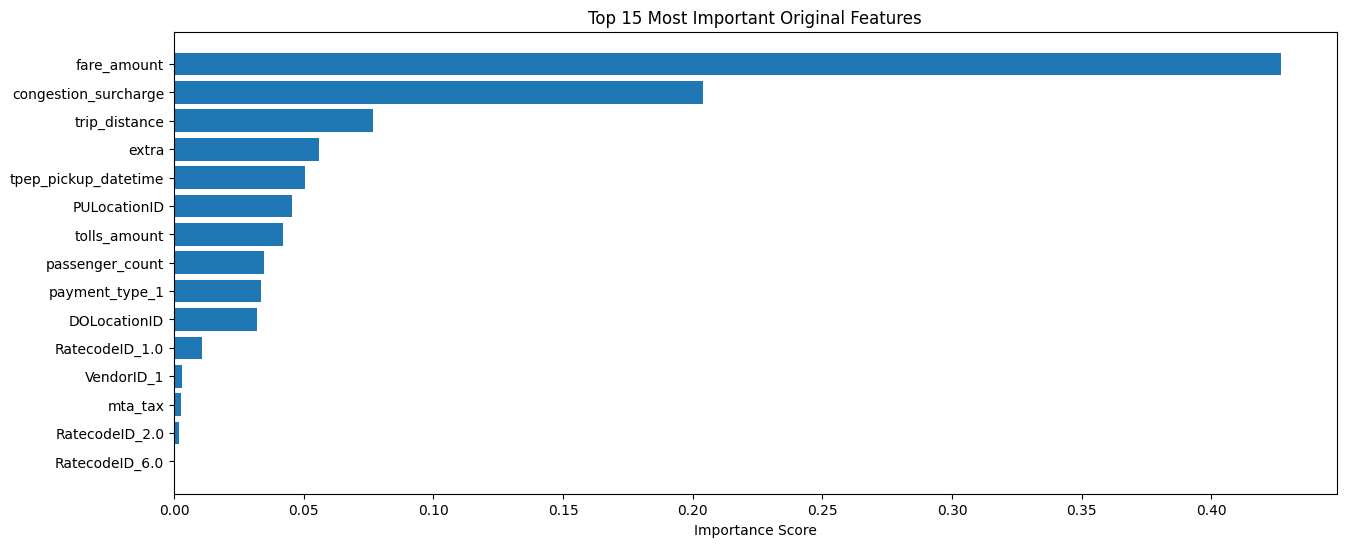

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()  # Most important at top
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Original Features')
plt.show()